Let's test calculating vertical heat flux as prescribed in Su et Al., 2020

(Su, Z., Torres, H., Klein, P., Thompson, A. F., Siegelman, L., Wang, J., et al. (2020). High‐frequency submesoscale motions enhance the upward vertical heat transport in the global ocean. Journal of Geophysical Research:  Oceans, 125, e2020JC016544. https:// doi.org/10.1029/2020JC016544)

SOME NOTES:
<W'T'> = bar(WT) - bar(W) bar(T)\
expand to 1 deg by 1 deg boxes for full meso inclusion
could diagnose meso by expanding time avg from 1 day to 7 days


The following are the exact steps utilized in this notebook to calculate vertical heat flux:
1. define W (vertical velocity) and T (Theta, potential temperature) within a 1 deg x 1 deg box centered at 39N, 158E in the LLC4320 dataset. Split into 4 0.5 deg x 0.5 deg sub-boxes.
2. interpolate W using grid_3d.interp along the z axis. This is necessary as Theta values are spatially centered within LLC pixels while W (vertical velocity) values are horizontally centered, but vertically shifted to the edges of LLC pixels.
3. calculate W and T spatial means in each 0.5 x 0.5 box for each hourly time t
4. calculate W' and T' by coarse graining the spatial means at each time t
5. define the total VHF with $C_p \rho W' T'$ for each time t 
6. Applying a Hanning window to reduce spectral leakage from the long time series
7. take the temporal fourier transforms of W' and T' to produce $\hat{W}, \hat{T}$
8. define LF and HF by respectively applying a low pass and high pass filter to $\hat{W}, \hat{T}$ using a mask and inverse fourier transform back into time space
9. define LF and HF VHF respectively with $C_p \rho W_{lowpass} T_{lowpass}$ and $C_p \rho W_{highpass} T_{highpass}$
10. calculate the LF, HF, and total VHF mean across all i,j for each time to produce a time series, weighting by cell surface areas

old:\
6. calculate the LF VHF with $C_p \rho <W' T'>$ for each time t where <> denotes taking the time average of each W' and T' set to 1 day averages:\
$<W' T'> = \bar{WT} - \bar{W} \bar{T}$ \
7. calculate the HF VHF by subtracting LF from LF + HF: $HF = (LF + HF) - LF = C_p \rho W' T' - C_p \rho <W' T'>$ at each time step t (hourly).

Below are more notes from relevant papers about adjacent methods/calculations

High level notes: (Directly from the paper)\
spatial scales are less than 0.5 deg (lon). LF is daily averages, HF is less than per day\
$VHF = Re[C_p \rho \hat{W} \hat{T}^* (k,\omega)]$, units are $W m^{-2} cph^{-1} cpkm^{-1}$\
$\hat{W}$ is the Fourier transform of vertical velocity\
$\hat{T}^*$ is the conjugate of the Fourier transform of the potential temperature\
${C_p}$ is the heat capacity of seawater\
${\rho}$ is potential density\
Remove the mean and linear trend in space and time of W and T before computing the $\omega-k$ cospectrum\
Next, multiply both detrended variables by a 3-D(x,y,t) Hanning window\
Cospectrum is calculate in a 6 deg lat by 6 deg lon boxes at 3-month hourly output.\
Azimuthally integrate the spectrum in wavenumber space to express the cospectrum in terms of the modulus of the horizontal wavenumber k


More detailed notes (from the supporting information doc):\
Advective heat flux is resolved at a 0.1 deg to 0.5 deg lon scale to be roughly 5 times the numerical resolution (to resolve physics)\
Vertical velocity W at this scale W' are the W anomalies from a 0.5 deg by 0.5 deg spatial mean, T' is defined similarly\
Vertical heat flux is defined as $C_p \rho <W' T'>$ where <> denotes a time average\
See Capet al. 2008a, 2008b;Su et al. 2018; Uchida et al. 2017 for spatial and temporal filters.

Okay let's take a look at these spatial and temporal filters from the papers listed

Capet al. 2008a:\
for all variables V, define a mesoscale-submesoscale break:\
$V = \bar{V} + (\tilde{V} - \bar{V}) + (V - \tilde{V})$ \
The first component is V' = mesoscale\
The second component is V'' = submesoscale\
$\bar{V}$ is the mean\
$V$ is a low-pass filter\
$\tilde{V}$ is a medium low pass-- this is defined as "a combination of temporal averaging over 2 days and horizontal smoothing(i.e., $2^n$ applications of a grid-scale five-point operator with a 12-km smoothing length with n = 4 for the submesoscale-resolving case\

Capet al. 2008b:\
Use the spatial and temporal high-pass filter described above to isolate submesoscale

Uchida et al. 2017:\
$u'' = u - \bar{u}^m$\
$u''$ are sub-monthly fluctuations\
$u$ are some values (was unclear?)\
$\bar{u}^m$ are monthly averages
This temporal high-pass filter can "act as a crude spatial high-pass filter"\

Su et al. 2018:\
The submesoscale component of vorticity $\zeta$, denoted $\zeta'$ are the anomalies of the daily mean of $\zeta$ from its .5 by .5 deg spatial mean 



In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.transforms import Affine2D

(np.float64(-0.5), np.float64(4099.5), np.float64(1298.5), np.float64(-0.5))

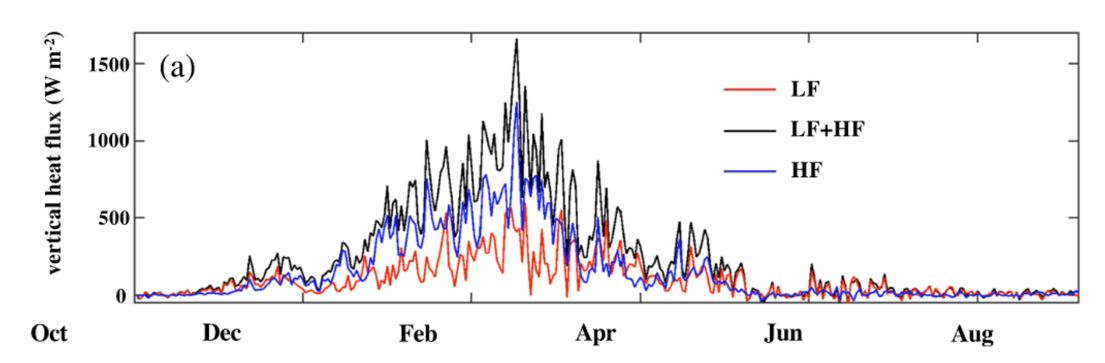

In [2]:
plt.figure(figsize=(14,8))
plt.imshow(plt.imread('su_fig_5_kuroshio.png'))
plt.axis('off')

I'm gonna replicate this figure:
Figure 5. Time series of vertical heat flux associated with scales <0.5° at 40‐m depth. Curves indicate heat fluxes calculated from daily mean model output (red, low‐frequency or LF), hourly snapshots (black, low‐frequency + highfrequency, or LF + HF), and the difference between the two (blue, high‐frequency or HF). The LF + HF time series have been daily averaged for easier comparison. Heat flux calculations are from a 1° × 1° box centered at a given location in each region. Panels (a) to (e), respectively, refer to the Kuroshio Extension (box centered at 39°N, 158°E), the Gulf Stream (box centered at 39°N, 66°W), (b) Northernmost Atlantic (box centered at 58°N, 24°W), (c) Agulhas Current (box centered at 43°S, 14°E), and (d) the Southern Ocean (box centered at 50°S, 87°E).

In [3]:
import xarray as xr
import numpy as np
import dask
import zarr
import xgcm 

0. Open LLC, visualize some data :)

In [4]:
# open LLC4320
LLC_full = xr.open_zarr('/orcd/data/abodner/003/LLC4320/LLC4320',consolidated=False)

In [5]:
# select face 7, depth = 40m
LLC_7 = LLC_full.isel(face = 7, k = 14)#, i = slice(3000,3100), j= slice(1000,1100))

In [6]:
def rotate_axes_90_clockwise(ax):
    """
    Robustly rotate a Matplotlib Axes 90 degrees clockwise by:
      - rendering the figure to an RGBA buffer,
      - cropping the pixels belonging to the given Axes,
      - rotating the image 90 deg clockwise,
      - placing the rotated image back into the figure at the same axes position,
      - removing the original Axes.

    Notes:
    - This rasterizes the axis contents (the result is an image, not vector art).
    - Colorbars or other axes that live outside the target `ax` are left alone.
    - Works reliably for full grids or arbitrary subsets.
    """
    fig = ax.figure

    # Force draw so renderer & sizes are correct
    fig.canvas.draw()
    renderer = fig.canvas.get_renderer()

    # Get pixel bbox of the axes (in display coordinates) via renderer-aware call
    bbox = ax.get_window_extent(renderer=renderer)  # Bbox in display (pixel) coords

    # Grab the full figure RGBA buffer (H x W x 4)
    buf = np.asarray(renderer.buffer_rgba())  # returns an (H,W,4) uint8 array

    H, W = buf.shape[0], buf.shape[1]

    # Convert bbox to integer pixel coords and crop.
    # Note: Bbox y coords are in display coordinates with origin at lower-left.
    x0, x1 = int(np.floor(bbox.x0)), int(np.ceil(bbox.x1))
    y0, y1 = int(np.floor(bbox.y0)), int(np.ceil(bbox.y1))

    # Convert to numpy row indices (origin at top-left)
    row0 = max(0, H - y1)
    row1 = min(H, H - y0)
    col0 = max(0, x0)
    col1 = min(W, x1)

    if row1 <= row0 or col1 <= col0:
        raise RuntimeError("Calculated zero-size axes crop — renderer/coords inconsistent.")

    axes_img = buf[row0:row1, col0:col1, :].copy()  # copy to be safe

    # Rotate 90 degrees clockwise. np.rot90 rotates counterclockwise, so use k=-1 (or k=3).
    rotated = np.rot90(axes_img, k=-1)

    # Create a new axes in the same figure position (figure coords) and show the rotated image.
    # We must compute the original axes position in figure coordinates:
    fig_x0, fig_y0, fig_w, fig_h = ax.get_position().bounds

    # Add overlaid axes and show the rotated image
    new_ax = fig.add_axes([fig_x0, fig_y0, fig_w, fig_h], anchor='C')  # same place
    new_ax.imshow(rotated, origin='upper', aspect='auto')
    new_ax.set_axis_off()

    # Remove the original axes (so only rotated image remains)
    fig.delaxes(ax)

    # Force redraw
    fig.canvas.draw()
    return new_ax

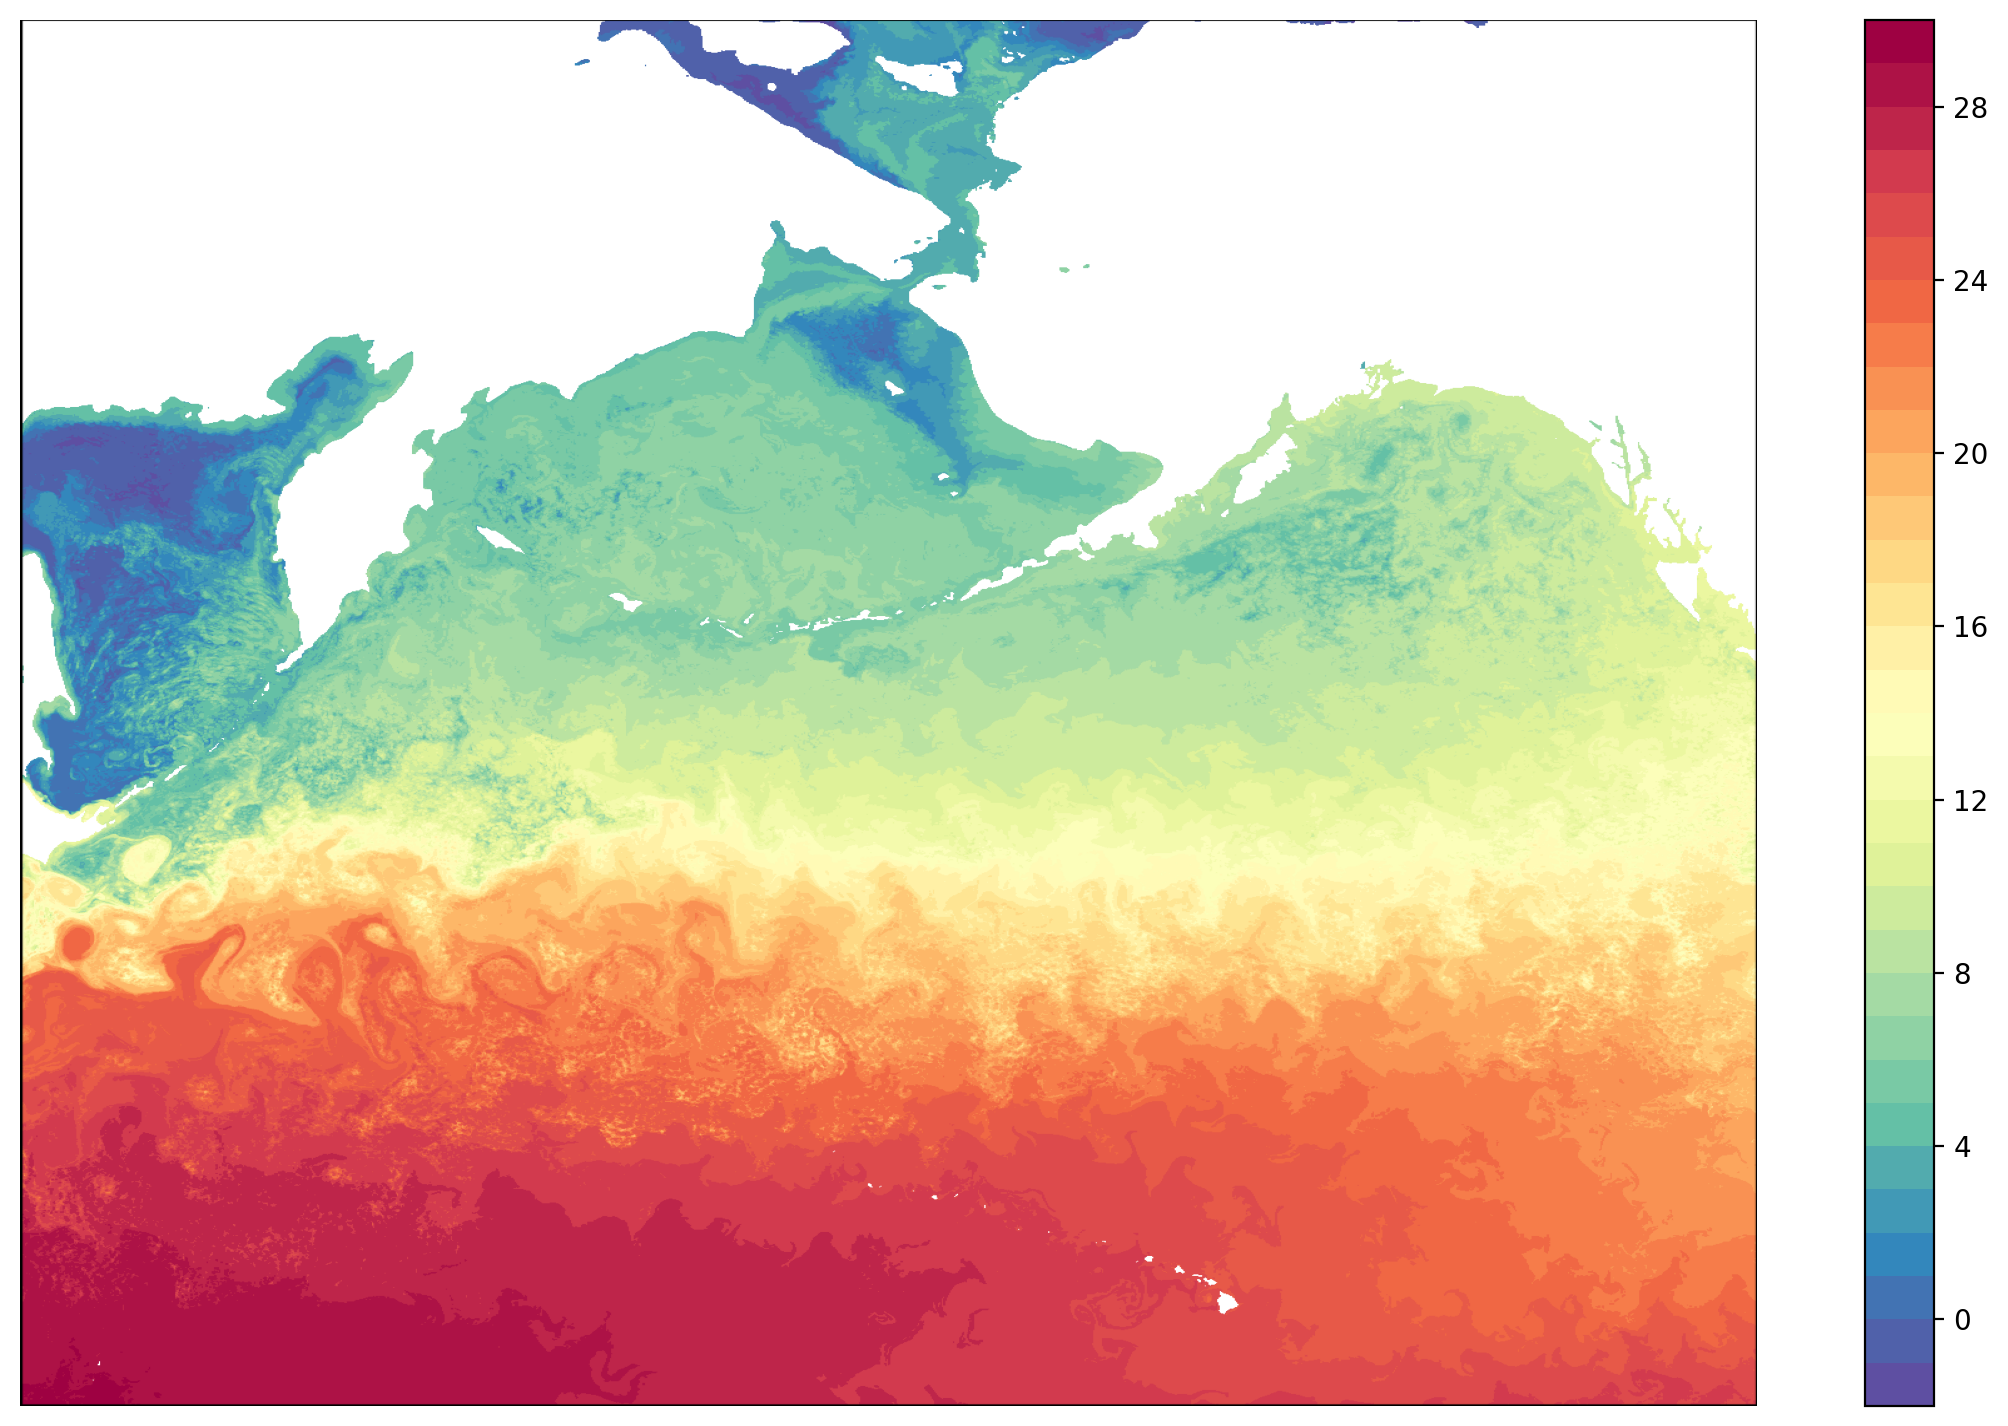

In [7]:
fig, ax = plt.subplots(figsize=(14,9),dpi=200)
cf = ax.contourf(LLC_7.isel(time = 1000)['Theta']['i'], LLC_7.isel(time = 1000)['Theta']['j'], LLC_7.isel(time = 1000)['Theta'], cmap="Spectral_r",vmin=np.min(LLC_7.isel(time = 1000)['Theta']).values,vmax=np.max(LLC_7.isel(time = 1000)['Theta']).values, levels = 30)
plt.colorbar(cf, ax = ax)

rotate_axes_90_clockwise(ax)

plt.show()

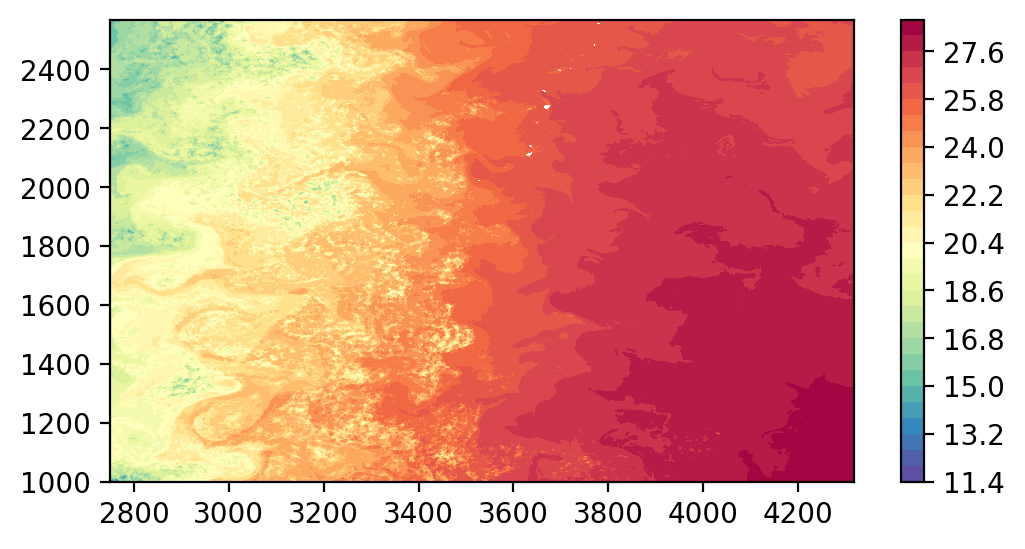

In [8]:
# subset to Kuroshio
LLC_sub = LLC_7.isel(i = slice(2750, 4320), j = slice(1000, 2570))

fig, ax = plt.subplots(figsize=(6,3),dpi=200)
cf = ax.contourf(LLC_sub.isel(time = 1000)['Theta']['i'], LLC_sub.isel(time = 1000)['Theta']['j'], LLC_sub.isel(time = 1000)['Theta'], cmap="Spectral_r",vmin=np.min(LLC_sub.isel(time = 1000)['Theta']).values,vmax=np.max(LLC_sub.isel(time = 1000)['Theta']).values, levels = 30)
plt.colorbar(cf, ax = ax)

plt.show()

1  Define W (vertical velocity) and T (Theta, potential temperature) within a 1 deg x 1 deg box centered at 39N, 158E in the LLC4320 dataset. Split into 4 0.5 deg x 0.5 deg sub-boxes.

In [9]:
# subset to 1 deg x 1 deg box centered at 159, 39
LLC_sub = LLC_full.isel(i = slice(2790, 2860), j = slice(745, 795), face = 7,k=14)


# calculate a .5 deg lat by .5 deg lon box in i,j:
XC = LLC_sub['XC'].values
YC = LLC_sub['YC'].values
lon_extent = (np.max(XC)) - (np.min(XC))
lat_extent = (np.max(YC)) - (np.min(YC))

box_dim = 0.5
num_lon_box = lon_extent/box_dim
num_lat_box = lat_extent/box_dim

In [10]:
lon_min = np.nanmin(XC)
lat_min = np.nanmin(YC)

# function to get i,j indices from target lat/lon vals
def i_j_from_lat_lon(coord_centers, num_boxes, coord_min):
    i = []
    j = []
    for box in range(int(num_boxes)):
        # get lat/lon in increments
        target = coord_min + 0.5 * box

        # get index closest to lat/lon targets
        dist = np.abs(coord_centers - target)
        flat_idx = np.nanargmin(dist)
        i_, j_ = np.unravel_index(flat_idx, coord_centers.shape)
        
        i.append(int(i_)), j.append(int(j_))
    return i, j

# function to get lat/lon vals from i, j indices
def lat_lon_from_i_j(LLC):
    lats = []
    lons = []
    lats.append(LLC['YC'][0,:].values)
    lons.append(LLC['XC'][:,0].values)

    return lats, lons


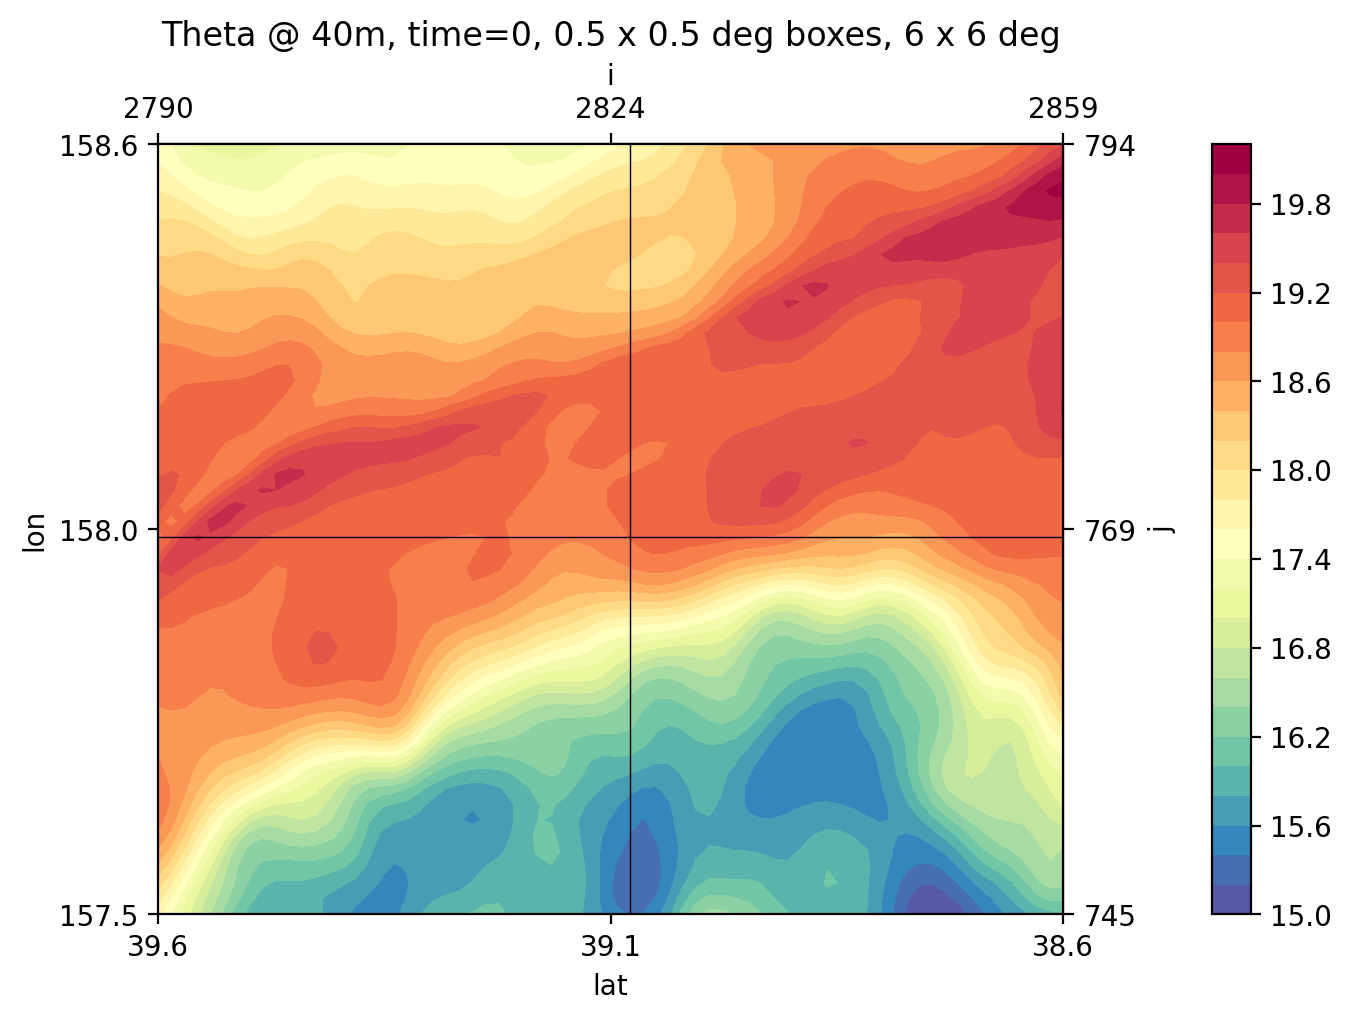

In [11]:
# visualize the subset and the .5x.5 boxes
fig, ax = plt.subplots(figsize=(8,5),dpi=200)

cf = ax.contourf(LLC_sub.isel(time = 0)['Theta']['i'], LLC_sub.isel(time = 0)['Theta']['j'], LLC_sub.isel(time = 0)['Theta'], cmap="Spectral_r",
    vmin=np.min(LLC_sub.isel(time = 0)['Theta']).values,vmax=np.max( LLC_sub.isel(time = 0)['Theta']).values, levels = 30)

i_inds = [int(vals)for vals in ([LLC_sub.isel(time = 0)['XC'][index, :]['j'].values for index in i_j_from_lat_lon(XC, num_lon_box, lon_min)[0]])]
j_inds = [int(vals)for vals in ([LLC_sub.isel(time = 0)['YC'][:, index]['i'].values for index in i_j_from_lat_lon(YC, num_lat_box, lat_min)[1]])]

for box in range(int(num_lon_box)):
    plt.axvline(j_inds[box], c = 'k',linewidth = 0.5)
    plt.axhline(i_inds[box], c = 'k',linewidth = 0.5)

lats, lons = lat_lon_from_i_j(LLC_sub.isel(time = 0))

ax.set_xticks(np.linspace(int(np.min(LLC_sub.isel(time = 0)['i'].values)), int(np.max(LLC_sub.isel(time = 0)['i'].values)), int(num_lon_box)+1))
ax.set_yticks(np.linspace(int(np.min(LLC_sub.isel(time = 0)['j'].values)), int(np.max(LLC_sub.isel(time = 0)['j'].values)), int(num_lon_box)+1))

yticks = ax.get_yticks() # i
xticks = ax.get_xticks() # j

ax.set_xticklabels([round(lats[0][idx],1) for idx in [int(round(i)) for i in np.linspace(0, len(lats[0]) -1, len(xticks))]])
ax.set_yticklabels([round(lons[0][idx],1) for idx in [int(round(i)) for i in np.linspace(0, len(lons[0]) -1, len(yticks))]])

# secondary axis
secax_x = ax.secondary_xaxis('top')
secax_x.set_xlim(ax.get_xlim())
secax_x.set_xticks(xticks)   # FIXED: use xticks here
secax_x.set_xticklabels([f"{int(t)}" for t in xticks])
secax_x.set_xlabel('i')
secax_x.tick_params(which='both', length=4)

secax_y = ax.secondary_yaxis('right')
secax_y.set_ylim(ax.get_ylim())
secax_y.set_yticks(yticks)   # FIXED: use yticks here
secax_y.set_yticklabels([f"{int(t)}" for t in yticks])
secax_y.set_ylabel('j')
secax_y.tick_params(which='both', length=4)


plt.title('Theta @ 40m, time=0, 0.5 x 0.5 deg boxes, 6 x 6 deg')
plt.colorbar(cf, ax=ax, pad=0.12)

ax.set_xlabel('lat')
ax.set_ylabel('lon')

plt.show()

2. interpolate W using grid_3d.interp along the z axis. This is necessary as Theta values are spatially centered within LLC pixels while W (vertical velocity) values are horizontally centered, but vertically shifted to the edges of LLC pixels.

In [12]:
# redefine LLC_sub without k selection for interpolation
LLC_sub = LLC_full.isel(i = slice(2790, 2860), j = slice(745, 795), face = 7)

# select temporal subset for testing-----
LLC_testing = LLC_sub.isel(time = slice(5000,5096)).chunk({'time': 24, 'i': -1, 'j': -1})

# define and interpolate vertical velocity
grid_3d = xgcm.Grid(
    LLC_testing,
    coords={
        'Z': {'center': 'k', 'left': 'k_p1'}},
    autoparse_metadata=False)

LLC_testing['W40'] = grid_3d.interp(LLC_testing['W'], 'Z', boundary='extend')

# define potential temp
LLC_testing['T40'] = LLC_testing['Theta']

LLC_testing = LLC_testing.isel(k=14)

In [13]:
# only grab relevant vars
LLC_testing = LLC_testing[['W40','T40','XC','YC','rA']]

3. calculate W and T spatial means in each 0.5 x 0.5 box for each hourly time t

In [14]:
# function to select i-j slices per box by lat/lon boxes
def i_j_slices(LLC, spacing):
    i_start, i_end = [], []
    j_start, j_end = [], []

    XC, YC= LLC['XC'].values, LLC['YC'].values

  #  i_min, j_min = np.min(LLC['i'].values), np.min(LLC['j'].values)

    extent = (np.nanmax(XC)) - (np.nanmin(XC))
    num_boxes = extent/spacing 

    lon_min, lat_min= np.nanmin(XC), np.nanmin(YC)

    for box in range(int(num_boxes)):
        # start lat/lon
        lon_start, lat_start = lon_min + spacing * box, lat_min + spacing * box

        # end lat/lon
        lon_end, lat_end = lon_min + spacing * box + spacing, lat_min + spacing * box + spacing

        # convert to i,j
        lon_dist_s, lat_dist_s = np.nanargmin(np.abs(XC - lon_start)),  np.nanargmin(np.abs(YC - lat_start))
        (_,i_s), (j_s,_) = np.unravel_index(lat_dist_s, YC.shape), np.unravel_index(lon_dist_s, XC.shape)

        lon_dist_e, lat_dist_e = np.nanargmin(np.abs(XC - lon_end)),  np.nanargmin(np.abs(YC - lat_end))
        (_,i_e), (j_e,_) = np.unravel_index(lat_dist_e, YC.shape), np.unravel_index(lon_dist_e, XC.shape)


        i_start.append(int(i_e)), i_end.append(int(i_s)), j_start.append(int(j_s)), j_end.append(int(j_e))
   # print (f'i: {i_start[::-1]}, {i_end[::-1]}, j: {j_start}, {j_end}, {int(num_boxes)}')
    return i_start[::-1], i_end[::-1], j_start, j_end, int(num_boxes)


# function to iterate through boxes in space and time, applying some f
def box_means(LLC, var):
    i_start, i_end, j_start, j_end, num_boxes = i_j_slices(LLC, 0.5)
    vals = []
    for i0, i1 in zip(i_start, i_end):
        for j0, j1 in zip(j_start, j_end):
            vals.append(
                LLC[var]
                .isel(i=slice(i0, i1), j=slice(j0, j1))
                .mean(dim=['i', 'j']))

    LLC[f'{var}_means'] = xr.concat(vals, dim='box')
    return LLC

def iterate_boxes(LLC, resolution_deg=0.5):

    i_start, i_end, j_start, j_end, num_boxes = i_j_slices(LLC, resolution_deg)

    box_id = 0
    for i0, i1 in zip(i_start, i_end):
        for j0, j1 in zip(j_start, j_end):
            # only yield boxes with valid size
            if (i1 - i0) > 0 and (j1 - j0) > 0:
                yield box_id, (i0, i1, j0, j1)
                box_id += 1

In [15]:
# calculate means
LLC_testing = box_means(LLC_testing, 'W40')
LLC_testing = box_means(LLC_testing, 'T40')

4. calculate W' and T' by subtracting the box spatial mean from each within-box pixel's W and T value along time (so each time has a W' and T') 

In [ ]:
# function to build a box index
def build_box_index(LLC, resolution_deg=0.5):
    box = xr.full_like(LLC["XC"], fill_value=-1).astype(int)

    for box_id, (i0, i1, j0, j1) in iterate_boxes(LLC, resolution_deg):
        box[j0:j1, i0:i1] = box_id
    return box

def calc_deviances(LLC, var, box_index):
    valid = box_index.where(box_index != -1)
    valid = valid.rename("box_id")

    # rename means to match groupby dimension names
    means = LLC[var].groupby(valid).mean().rename("means")

    # subtract box means from each cell
    anomalies = LLC[var].groupby(valid) - means

    LLC[f"{var}_prime"] = anomalies
    return LLC

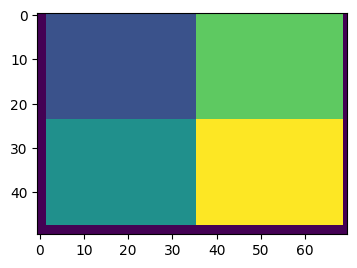

In [17]:
# build box index
box_index = build_box_index(LLC_testing).load()
plt.figure(figsize=(4,6))
plt.imshow(box_index)

In [18]:
# calculate deviances from the means
LLC_testing = calc_deviances(LLC_testing, 'W40', box_index)
LLC_testing = calc_deviances(LLC_testing, 'T40', box_index)

/home/codycruz/.venv/lib64/python3.12/site-packages/dask/array/core.py:4997: PerformanceWarning: Increasing number of chunks by factor of 70
  result = blockwise(
/home/codycruz/.venv/lib64/python3.12/site-packages/dask/array/core.py:4997: PerformanceWarning: Increasing number of chunks by factor of 70
  result = blockwise(


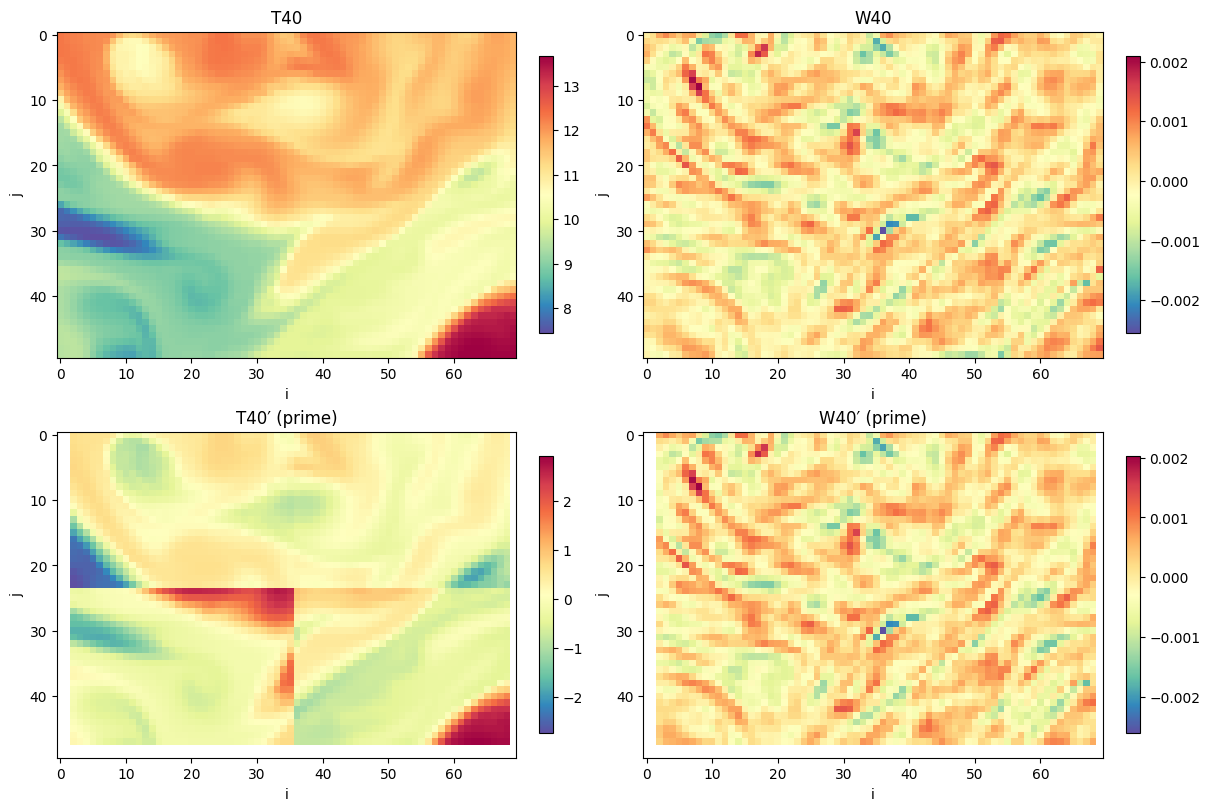

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)

ds = LLC_testing.isel(time=0)

# ----- T40 (upper-left) -----
im_T = axs[0, 0].imshow(ds['T40'], aspect='auto', cmap='Spectral_r')
axs[0, 0].set_title("T40")
fig.colorbar(im_T, ax=axs[0, 0], shrink=0.85)

# ----- T40' (lower-left) -----
im_Tp = axs[1, 0].imshow(ds['T40_prime'], aspect='auto', cmap='Spectral_r')
axs[1, 0].set_title("T40′ (prime)")
fig.colorbar(im_Tp, ax=axs[1, 0], shrink=0.85)

# ----- W40 (upper-right) -----
im_W = axs[0, 1].imshow(ds['W40'], aspect='auto', cmap='Spectral_r')
axs[0, 1].set_title("W40")
fig.colorbar(im_W, ax=axs[0, 1], shrink=0.85)

# ----- W40' (lower-right) -----
im_Wp = axs[1, 1].imshow(ds['W40_prime'], aspect='auto', cmap='Spectral_r')
axs[1, 1].set_title("W40′ (prime)")
fig.colorbar(im_Wp, ax=axs[1, 1], shrink=0.85)

# Label axes
for ax in axs.ravel():
    ax.set_xlabel("i")
    ax.set_ylabel("j")

plt.show()

5. calculate the LF+HF VHF with $C_p \rho W' T'$ for each time t 

In [ ]:

C_p, rho = 3900, 1025
total_VHF = C_p * rho * LLC_testing['W40_prime'] * LLC_testing['T40_prime']

6. calculate the LF VHF with $C_p \rho <W' T'>$ for each time t where <> denotes taking the time average of each W' and T' set to 1 day averages\
$<W' T'> = \bar{WT} - \bar{W} \bar{T}$ 

In [42]:
# define function to calculate LF components
def calc_LF(LLC, LF_average, box_width, box_index):
    # compute WT, W< T box means hourly
    i_start, i_end, j_start, j_end, num_boxes = i_j_slices(LLC, box_width)
    WT_list = []
    W_list = []
    T_list = []

    for i0, i1 in zip(i_start, i_end):
        for j0, j1 in zip(j_start, j_end):

            W_box = LLC["W40"].isel(i=slice(i0, i1), j = slice(j0, j1))
            T_box = LLC["T40"].isel(i=slice(i0, i1), j = slice(j0, j1))

            WT_box_mean = (W_box * T_box).mean(dim = ["i", "j"])
            W_box_mean  =  W_box.mean(dim = ["i", "j"])
            T_box_mean  =  T_box.mean(dim = ["i", "j"])

            WT_list.append(WT_box_mean)
            W_list.append(W_box_mean)
            T_list.append(T_box_mean)

    # stack into shape (box, time)
    WT = xr.concat(WT_list, dim = "box")
    Wm = xr.concat(W_list,  dim = "box")
    Tm = xr.concat(T_list,  dim = "box")

    # coarsen in time for LF average
    WT_LF = WT.coarsen(time = LF_average, boundary="trim").mean()
    Wm_LF = Wm.coarsen(time = LF_average, boundary="trim").mean()
    Tm_LF = Tm.coarsen(time = LF_average, boundary="trim").mean()

    # calc covariance
    LF_cov = WT_LF - (Wm_LF * Tm_LF)

    LF_cov.name = "Wprime_Tprime_LF"

    return LF_cov

In [45]:
LF_VHF = C_p * rho * calc_LF(LLC_testing, 24, 0.5, box_index)

7. calculate the HF VHF by subtracting LF from LF + HF: $HF = (LF + HF) - LF = C_p \rho W' T' - C_p \rho <W' T'>$ at each time step t (hourly).

In [ ]:
# expand LF_VHF to match the shape of total_VHF to calculate HF_VHF
nt = total_VHF.sizes["time"]
nLF = LF_VHF.sizes["time"]

# expect nt = 24 * nLF
assert nt == 24 * nLF, "Time dimensions must satisfy total = 24 * LF"

# build the mapping index
idx = np.repeat(np.arange(nLF), 24)

# now index LF_VHF using integer indexing
LF_expanded = LF_VHF.isel(time = xr.DataArray(idx, dims="time"))
LF_expanded = LF_expanded.assign_coords(time = total_VHF.time)
HF_VHF = total_VHF - LF_expanded

/home/codycruz/.venv/lib64/python3.12/site-packages/dask/array/core.py:4997: PerformanceWarning: Increasing number of chunks by factor of 96
  result = blockwise(


Visualize VHF

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-12181.392..10557.077].


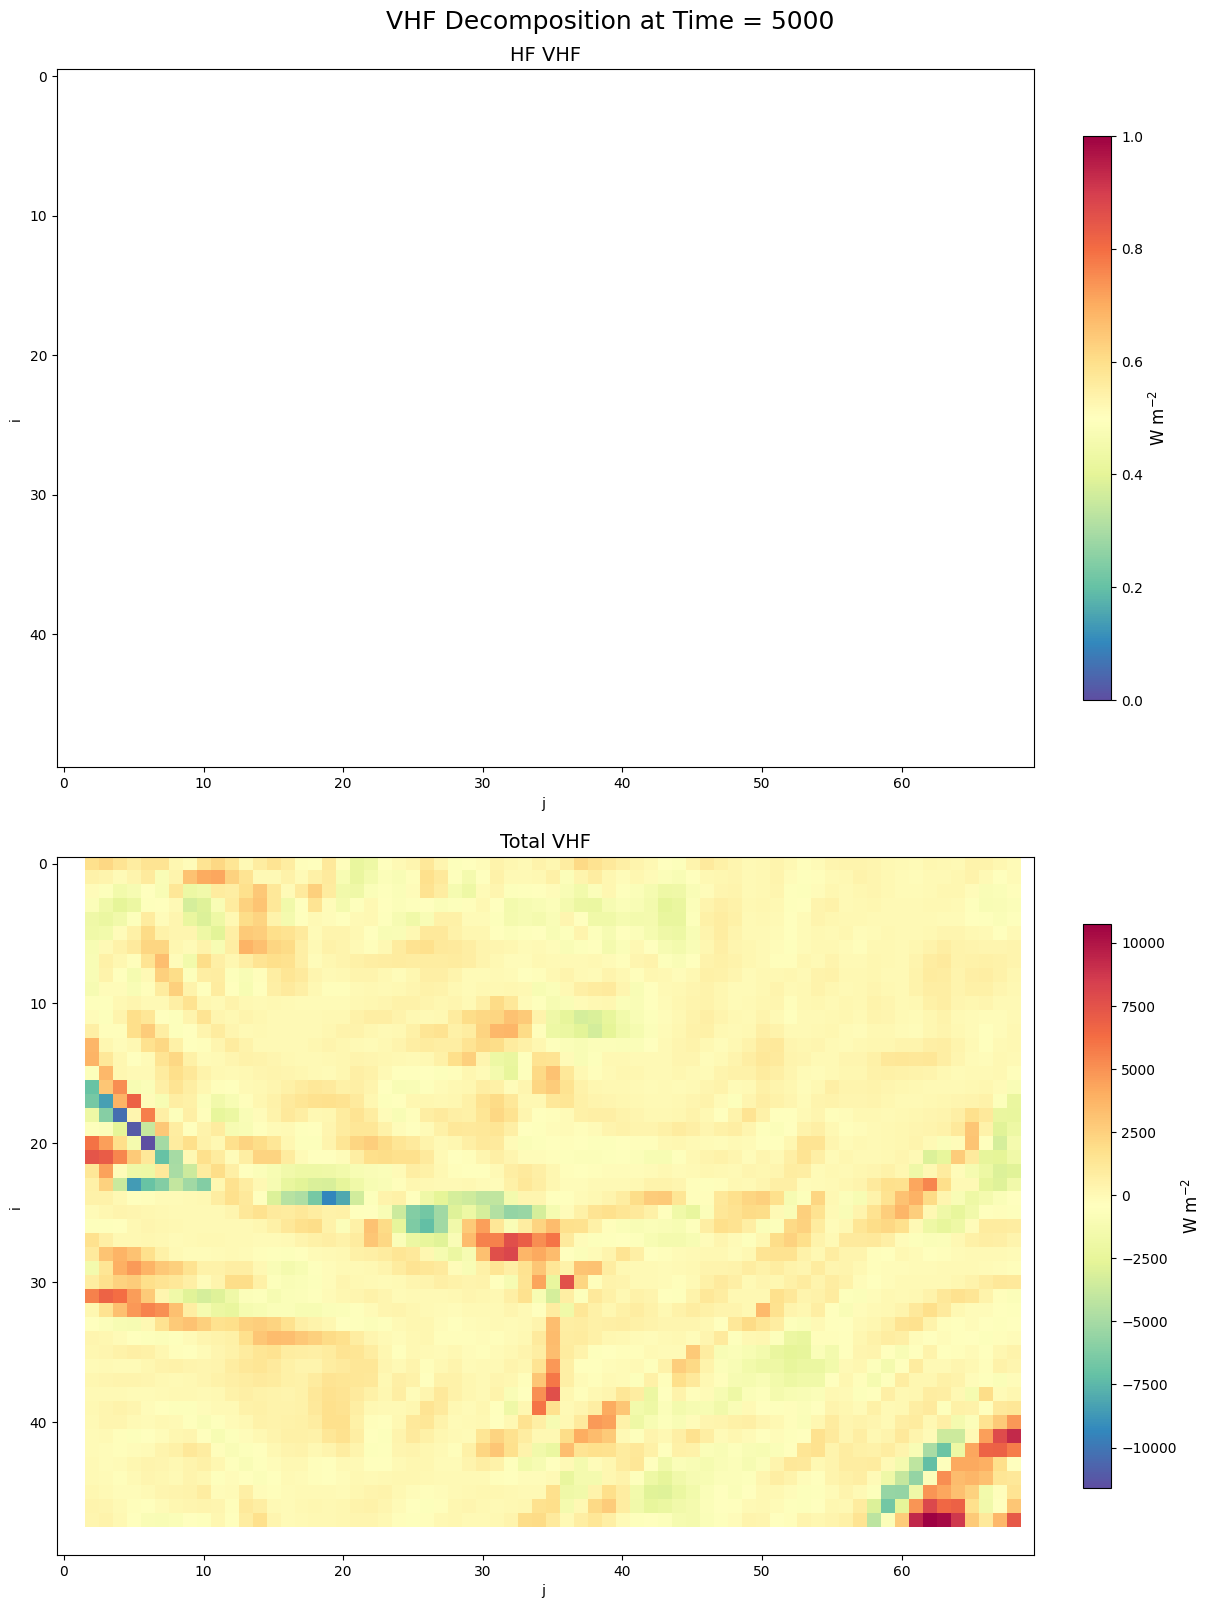

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(12, 16), constrained_layout=True)

cmap = 'Spectral_r'

fields = [
    #('LF VHF',     LF_VHF.isel(time=0)),
    ("HF VHF",    HF_VHF.isel(time=0)),
    ("Total VHF", total_VHF.isel(time=0)),
]

for ax, (title, da) in zip(axes, fields):
    im = ax.imshow(da, cmap=cmap)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("j ")
    ax.set_ylabel("i ")
    
    # add colorbar for each subplot
    cbar = fig.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label("W m$^{-2}$", fontsize=12)

fig.suptitle("VHF Decomposition at Time = 5000", fontsize=18)

plt.show()

8. calculate the LF, HF, and total VHF mean across all i,j for each time to produce a time series, weighting by cell surface areas

In [65]:
# take means across i,j, weighting by cell surface areas
weights = LLC_testing['rA']
HF_VHF_ts = (HF_VHF * weights).sum(dim=("i","j")) / weights.sum(dim=("i","j"))
total_VHF_ts = (total_VHF * weights).sum(dim=("i","j")) / weights.sum(dim=("i","j"))

In [ ]:
# expand LF to hourly resolution
idx = np.repeat(np.arange(LF_VHF.sizes["time"]), 24)
LF_expanded_ts = LF_VHF.isel(time=xr.DataArray(idx, dims="time"))
LF_expanded_ts = LF_expanded_ts.assign_coords(time=HF_VHF_ts.time)

fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(total_VHF_ts.time, total_VHF_ts, color="black", label="Total VHF", linewidth=2)
ax.plot(HF_VHF_ts.time, HF_VHF_ts, color="blue", label="HF VHF", linewidth=1.5)
ax.plot(total_VHF_ts.time, LF_expanded_ts, color="red", label="LF VHF", linewidth=2)

ax.set_title("VHF Decomposition — Time Series", fontsize=18)
ax.set_xlabel("Time", fontsize=14)
ax.set_ylabel("W m$^{-2}$", fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=12)

plt.show()